In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, TemporalData
from sklearn.preprocessing import MinMaxScaler
import optuna
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import DataLoader # Ensure DataLoader is imported from torch_geometric.data

In [50]:
# Membaca dataset
df = pd.read_csv("harga_beras_premium.csv")
print(df.head(5))
print(df.shape)

      Tanggal      Komoditas             Provinsi    Harga
0  17/05/2022  Beras Premium  Nusa Tenggara Barat  10667.0
1  17/05/2022  Beras Premium     Sulawesi Selatan  10918.0
2  17/05/2022  Beras Premium             Bengkulu  11475.0
3  17/05/2022  Beras Premium               Banten  11163.0
4  17/05/2022  Beras Premium       D.I Yogyakarta  11240.0
(41648, 4)


In [51]:
# Mengecek missing values dari dataframe
null_values = df.isnull().sum()
null_values

Tanggal         0
Komoditas       0
Provinsi        0
Harga        4294
dtype: int64

In [52]:
# Menghapus missing value dari dataframe
df_cleaned = df.dropna()
print(df_cleaned.isnull().sum())
print(df_cleaned.shape)

Tanggal      0
Komoditas    0
Provinsi     0
Harga        0
dtype: int64
(37354, 4)


In [53]:
# Konversi kolom Tanggal ke datetime
df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
df_cleaned.head(5)

/tmp/ipykernel_5933/1040587474.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
/tmp/ipykernel_5933/1040587474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])


,Tanggal,Komoditas,Provinsi,Harga
0,2022-05-17,Beras Premium,Nusa Tenggara Barat,10667.0
1,2022-05-17,Beras Premium,Sulawesi Selatan,10918.0
2,2022-05-17,Beras Premium,Bengkulu,11475.0
3,2022-05-17,Beras Premium,Banten,11163.0
4,2022-05-17,Beras Premium,D.I Yogyakarta,11240.0


In [54]:
df_cleaned = df_cleaned.sort_values(['Tanggal', 'Provinsi'])

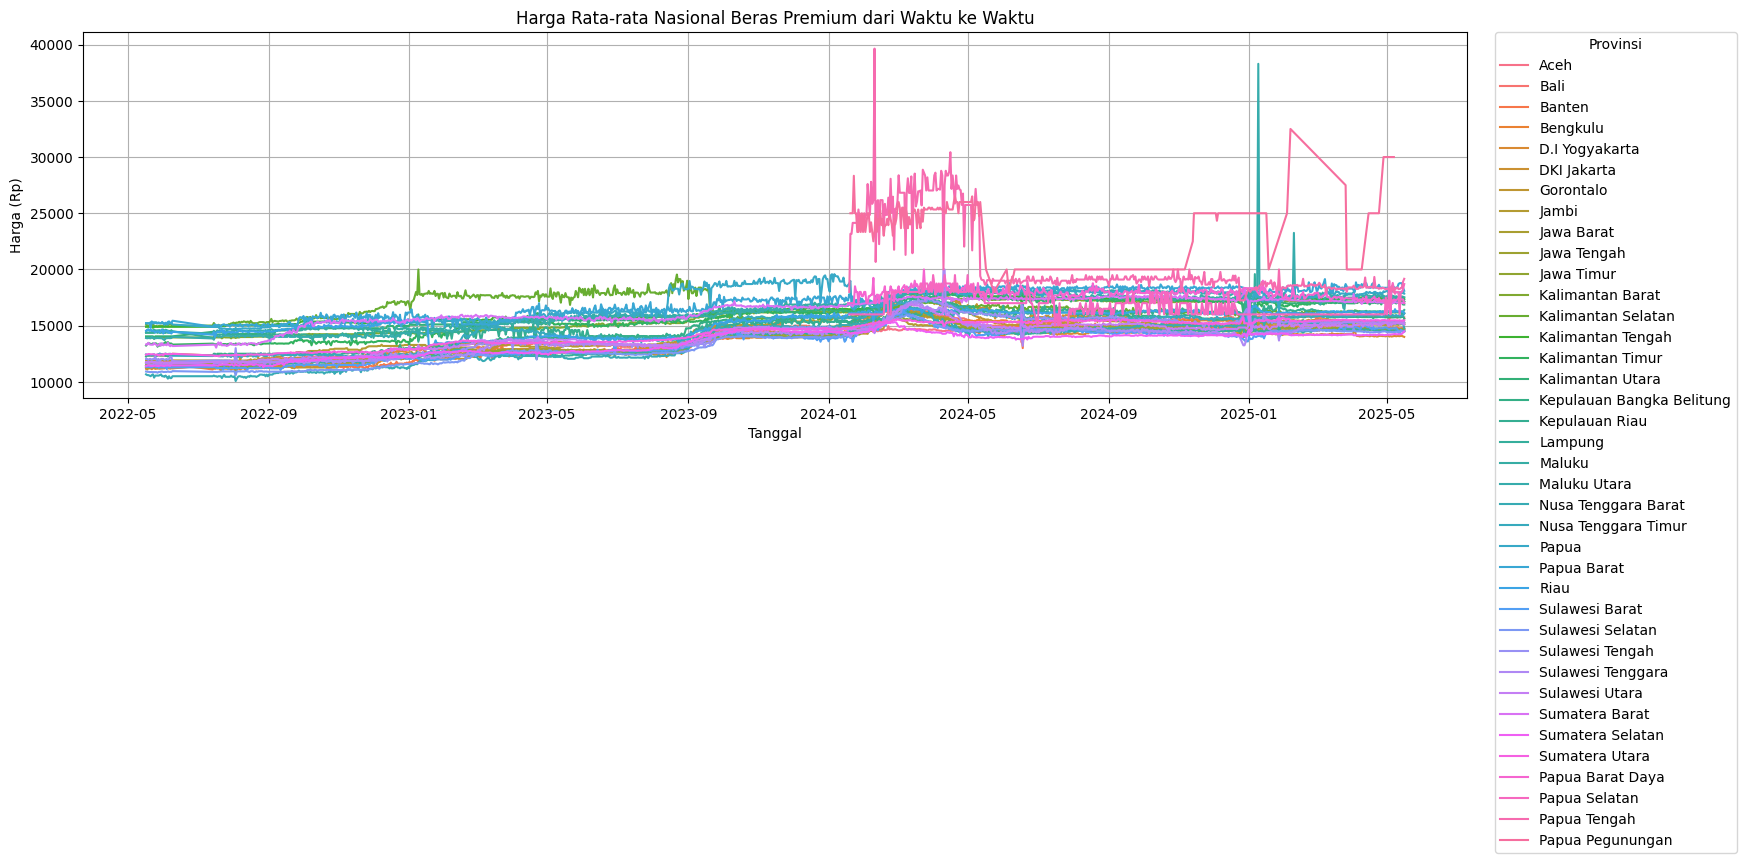

In [55]:
plt.figure(figsize=(20, 7))
sns.lineplot(x='Tanggal', y='Harga', data=df_cleaned, hue='Provinsi')
plt.title('Harga Rata-rata Nasional Beras Premium dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.grid(True)
# Letakkan legenda di luar plot
plt.legend(title='Provinsi', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
# Sesuaikan layout agar legenda tidak terpotong
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

In [56]:
# Pivot Data
df_pivot = df_cleaned.pivot(index='Tanggal', columns='Provinsi', values='Harga')
df_pivot.head(5)

Provinsi,Aceh,Bali,Banten,Bengkulu,D.I Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua Tengah,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Tanggal,,,,,,,,,,,,,,,,,,,,,
2022-05-17,11762.0,11396.0,11163.0,11475.0,11240.0,12333.0,11258.0,11909.0,11558.0,11456.0,...,NaN,14548.0,11333.0,10918.0,12036.0,11653.0,11762.0,13320.0,11406.0,12416.0
2022-05-18,11703.0,11407.0,11186.0,11475.0,11240.0,12333.0,11092.0,11909.0,11559.0,11431.0,...,NaN,14586.0,11333.0,10895.0,12036.0,11740.0,11762.0,13317.0,11441.0,12448.0
2022-05-19,11762.0,11407.0,11286.0,11475.0,11200.0,12333.0,11250.0,11909.0,11559.0,11384.0,...,NaN,14685.0,11333.0,10895.0,11950.0,11575.0,11762.0,13472.0,11469.0,12474.0
2022-05-20,11811.0,11407.0,11225.0,11475.0,11200.0,12333.0,11258.0,11909.0,11561.0,11431.0,...,NaN,14537.0,11333.0,10873.0,12036.0,11573.0,11754.0,13332.0,11441.0,12471.0
2022-05-21,11752.0,11407.0,11225.0,11475.0,11200.0,12333.0,11275.0,11909.0,11580.0,11368.0,...,NaN,14667.0,11283.0,10873.0,12040.0,11544.0,11792.0,13312.0,11406.0,12447.0


In [57]:
# Pastikan tanggal terurut naik
df_pivot = df_pivot.sort_index()

# 1. Interpolasi linear untuk lubang di antara dua titik valid
df_interp = df_pivot.interpolate(method='linear', limit_direction='both')

# 2. Isi sisa missing di ujung (awal/akhir) dengan forward/backward fill
df_cleaned_ts_prices_only = (
    df_interp
    .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
    .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya
)

df_cleaned_ts_prices_only.head()

/tmp/ipykernel_5933/2525360441.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
/tmp/ipykernel_5933/2525360441.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya


Provinsi,Aceh,Bali,Banten,Bengkulu,D.I Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua Tengah,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Tanggal,,,,,,,,,,,,,,,,,,,,,
2022-05-17,11762.0,11396.0,11163.0,11475.0,11240.0,12333.0,11258.0,11909.0,11558.0,11456.0,...,18000.0,14548.0,11333.0,10918.0,12036.0,11653.0,11762.0,13320.0,11406.0,12416.0
2022-05-18,11703.0,11407.0,11186.0,11475.0,11240.0,12333.0,11092.0,11909.0,11559.0,11431.0,...,18000.0,14586.0,11333.0,10895.0,12036.0,11740.0,11762.0,13317.0,11441.0,12448.0
2022-05-19,11762.0,11407.0,11286.0,11475.0,11200.0,12333.0,11250.0,11909.0,11559.0,11384.0,...,18000.0,14685.0,11333.0,10895.0,11950.0,11575.0,11762.0,13472.0,11469.0,12474.0
2022-05-20,11811.0,11407.0,11225.0,11475.0,11200.0,12333.0,11258.0,11909.0,11561.0,11431.0,...,18000.0,14537.0,11333.0,10873.0,12036.0,11573.0,11754.0,13332.0,11441.0,12471.0
2022-05-21,11752.0,11407.0,11225.0,11475.0,11200.0,12333.0,11275.0,11909.0,11580.0,11368.0,...,18000.0,14667.0,11283.0,10873.0,12040.0,11544.0,11792.0,13312.0,11406.0,12447.0


In [58]:
# Ambil data provinsi
provinsi_list = sorted(df_cleaned_ts_prices_only.columns.tolist())

# Mengubah data tiap provinsi menjadi index
provinsi_to_index = {prov: idx for idx, prov in enumerate(provinsi_list)}

print(provinsi_list)
print(f"Number of provinces (nodes): {len(provinsi_list)}")
print(provinsi_to_index)

['Aceh', 'Bali', 'Banten', 'Bengkulu', 'D.I Yogyakarta', 'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Papua Barat Daya', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']
Number of provinces (nodes): 38
{'Aceh': 0, 'Bali': 1, 'Banten': 2, 'Bengkulu': 3, 'D.I Yogyakarta': 4, 'DKI Jakarta': 5, 'Gorontalo': 6, 'Jambi': 7, 'Jawa Barat': 8, 'Jawa Tengah': 9, 'Jawa Timur': 10, 'Kalimantan Barat': 11, 'Kalimantan Selatan': 12, 'Kalimantan Tengah': 13, 'Kalimantan Timur': 14, 'Kalimantan Utara': 15, 'Kepulauan Bangka Belitung': 16, 'Kepulauan Ria

In [59]:
# Define feature engineering function
def enhance_features(df_series, col_name='Harga'):
    df = pd.DataFrame({col_name: df_series})
    df_out = pd.DataFrame(index=df.index)
    df_out[col_name] = df[col_name] # Original price
    df_out['MA7'] = df[col_name].rolling(window=7, min_periods=1).mean()
    df_out['MA30'] = df[col_name].rolling(window=30, min_periods=1).mean()
    df_out['price_change'] = df[col_name].diff().fillna(0)
    df_out['price_change_pct'] = df[col_name].pct_change().fillna(0).replace([np.inf, -np.inf], 0)
    df_out['volatility7'] = df[col_name].rolling(window=7, min_periods=1).std().fillna(0)
    return df_out

# Apply feature engineering
all_province_features_list = []
for prov_name in provinsi_list:
    province_price_series = df_cleaned_ts_prices_only[prov_name]
    enhanced_df = enhance_features(province_price_series, col_name='Harga')
    # Handle any NaNs produced by rolling/diff, especially at the beginning
    enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
    all_province_features_list.append(enhanced_df.values)

# Stack into a 3D numpy array: (timesteps, num_provinces, num_engineered_features)
features_np_array = np.stack(all_province_features_list, axis=1)
num_engineered_features = features_np_array.shape[2]
print(f"Shape of features_np_array: {features_np_array.shape}") # (timesteps, num_provinces, num_features)
print(f"Number of engineered features per province: {num_engineered_features}")

# Scaling: Fit scalers on the training portion of the time series data
# Determine split point in timesteps (approx. for fitting scalers)
# This should align with the timesteps that will form the training sequences
# Let's define sequence_length here as it's needed for calculating the split point for scalers
sequence_length = 30 # Must be same as used later
num_total_samples = features_np_array.shape[0] - sequence_length - 30 + 1 # 30 is prediction horizon
num_train_samples_for_scaler_fit = int(num_total_samples * 0.8)
# The last timestep index involved in the input of the last training sample
timesteps_for_scaler_fit = sequence_length + num_train_samples_for_scaler_fit -1 + sequence_length

features_np_array_scaled = np.copy(features_np_array)
scalers_province_feature = [[MinMaxScaler() for _ in range(num_engineered_features)] for _ in range(len(provinsi_list))]

for p_idx in range(len(provinsi_list)):
    for f_idx in range(num_engineered_features):
        scaler = scalers_province_feature[p_idx][f_idx]
        # Fit on the portion of data that will form training inputs
        data_to_fit = features_np_array[:timesteps_for_scaler_fit, p_idx, f_idx].reshape(-1, 1)
        if len(data_to_fit) > 0: # Ensure data is not empty
             scaler.fit(data_to_fit)
             features_np_array_scaled[:, p_idx, f_idx] = scaler.transform(features_np_array[:, p_idx, f_idx].reshape(-1, 1)).flatten()
        else: # Fallback if data_to_fit is empty (should not happen with proper setup)
             features_np_array_scaled[:, p_idx, f_idx] = 0 # Or handle as error

print(f"Shape of features_np_array_scaled: {features_np_array_scaled.shape}")
# The first feature (index 0) is 'Harga'
feature_names = ['Harga', 'MA7', 'MA30', 'price_change', 'price_change_pct', 'volatility7']
print(f"Engineered features: {feature_names}")

/tmp/ipykernel_5933/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_5933/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_5933/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_5933/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use o

Shape of features_np_array: (1062, 38, 6)
Number of engineered features per province: 6
Shape of features_np_array_scaled: (1062, 38, 6)
Engineered features: ['Harga', 'MA7', 'MA30', 'price_change', 'price_change_pct', 'volatility7']


In [60]:
edges = {
    'Aceh': ['Sumatera Utara'],
    'Sumatera Utara': ['Aceh', 'Sumatera Barat', 'Riau'],
    'Sumatera Barat': ['Sumatera Utara', 'Riau', 'Jambi'],
    'Riau': ['Sumatera Utara', 'Sumatera Barat', 'Jambi', 'Kepulauan Riau'],
    'Kepulauan Riau': ['Riau'],
    'Jambi': ['Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Bengkulu'],
    'Bengkulu': ['Sumatera Barat', 'Jambi', 'Sumatera Selatan', 'Lampung'],
    'Sumatera Selatan': ['Jambi', 'Bengkulu', 'Lampung', 'Kepulauan Bangka Belitung'],
    'Kepulauan Bangka Belitung': ['Sumatera Selatan'],
    'Lampung': ['Bengkulu', 'Sumatera Selatan', 'Banten'],
    'DKI Jakarta': ['Banten', 'Jawa Barat'],
    'Jawa Barat': ['DKI Jakarta', 'Banten', 'Jawa Tengah'],
    'Banten': ['Lampung', 'DKI Jakarta', 'Jawa Barat'],
    'Jawa Tengah': ['Jawa Barat', 'D.I Yogyakarta', 'Jawa Timur'],
    'D.I Yogyakarta': ['Jawa Tengah', 'Jawa Timur'],
    'Jawa Timur': ['Jawa Tengah', 'D.I Yogyakarta', 'Bali'],
    'Bali': ['Jawa Timur', 'Nusa Tenggara Barat'],
    'Nusa Tenggara Barat': ['Bali', 'Nusa Tenggara Timur'],
    'Nusa Tenggara Timur': ['Nusa Tenggara Barat'],
    'Kalimantan Barat': ['Kalimantan Tengah'],
    'Kalimantan Tengah': ['Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Timur'],
    'Kalimantan Selatan': ['Kalimantan Tengah', 'Kalimantan Timur'],
    'Kalimantan Timur': ['Kalimantan Tengah', 'Kalimantan Selatan', 'Kalimantan Utara'],
    'Kalimantan Utara': ['Kalimantan Timur'],
    'Sulawesi Utara': ['Gorontalo'],
    'Gorontalo': ['Sulawesi Utara', 'Sulawesi Tengah'],
    'Sulawesi Tengah': ['Gorontalo', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tenggara'],
    'Sulawesi Barat': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Sulawesi Selatan': ['Sulawesi Tengah', 'Sulawesi Barat', 'Sulawesi Tenggara'],
    'Sulawesi Tenggara': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Maluku': ['Maluku Utara'],
    'Maluku Utara': ['Maluku'],
    'Papua Barat': ['Papua'],
    'Papua': ['Papua Barat', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah'],
    'Papua Pegunungan': ['Papua', 'Papua Tengah'],
    'Papua Selatan': ['Papua', 'Papua Tengah'],
    'Papua Tengah': ['Papua', 'Papua Pegunungan', 'Papua Selatan'],
    'Papua Barat Daya': ['Papua Barat']
}

In [61]:
# List kosong untuk menampung index
edge_index = []

# Untuk setiap data dari edges akan dikonversi menjadi index yang ada di dictionary provinsi_to_index
for src, destinations in edges.items():
    for dst in destinations:
        i, j = provinsi_to_index[src], provinsi_to_index[dst]
        edge_index.append((i, j))
        edge_index.append((j, i))  # graf tidak berarah

import torch
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

print(f"Created edge_index tensor of shape: {edge_index.shape}")
print(f"Number of edges: {edge_index.shape[1]}")

Created edge_index tensor of shape: torch.Size([2, 176])
Number of edges: 176


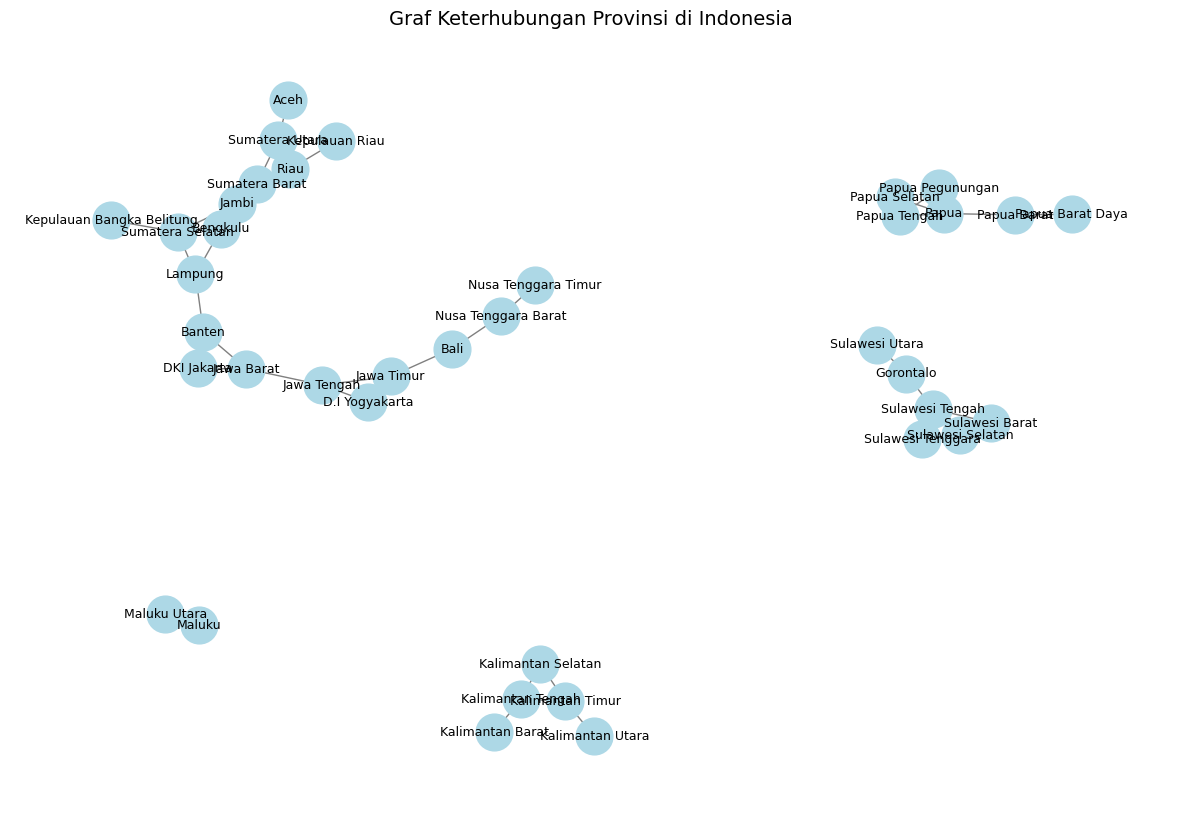

In [62]:
import networkx as nx
# Buat graf kosong
G = nx.Graph()

# Tambahkan node
G.add_nodes_from(provinsi_to_index.keys())

# Convert edges dictionary to a list of tuples (source, destination) for NetworkX
edge_list = []
for src, destinations in edges.items():
    for dst in destinations:
        edge_list.append((src, dst))

# Tambahkan edge menggunakan list edge yang telah dibuat
G.add_edges_from(edge_list)

# Layout graf (gunakan spring layout agar terlihat rapi)
pos = nx.spring_layout(G, seed=42)  # bisa juga pakai nx.kamada_kawai_layout(G)

# Plot graf
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

plt.title("Graf Keterhubungan Provinsi di Indonesia", fontsize=14)
plt.axis('off')
plt.show()

In [63]:
# Define sequence length and prediction horizon
# sequence_length is already defined in CELL 10 as 30. We'll use it.
# prediction_horizon: How many steps ahead we want to predict.
# Based on the num_total_samples calculation in CELL 10, a horizon of 30 was implied.
prediction_horizon = 30

# Get dimensions
num_timesteps = features_np_array_scaled.shape[0]
num_nodes = features_np_array_scaled.shape[1]  # Number of provinces
num_features_per_node = features_np_array_scaled.shape[2] # Number of engineered features

dataset = []

# Iterate to create sequences
# The number of samples will be num_timesteps - sequence_length - prediction_horizon + 1
for i in range(num_timesteps - sequence_length - prediction_horizon + 1):
    # Input sequence: (sequence_length, num_nodes, num_features_per_node)
    input_sequence_np = features_np_array_scaled[i : i + sequence_length, :, :]
    
    # Target: Price ('Harga' feature, which is index 0) at prediction_horizon steps after the input sequence
    # Shape: (num_nodes,)
    target_price_np = features_np_array_scaled[i + sequence_length + prediction_horizon - 1, :, 0]
    
    # Convert to PyTorch tensors
    input_tensor = torch.tensor(input_sequence_np, dtype=torch.float)
    target_tensor = torch.tensor(target_price_np, dtype=torch.float)
    
    # Create a PyG Data object for each sample
    # We store the input sequence as 'x_seq'
    # edge_index is static for all graphs in the sequence and across all samples
    data_sample = Data(
        x_seq=input_tensor, 
        y=target_tensor, 
        edge_index=edge_index
    )
    # Explicitly setting num_nodes can be helpful for PyG, though it often infers it.
    # Since our 'x' is not the standard [num_nodes, num_features], but 'x_seq',
    # it's good practice if the model relies on data.num_nodes.
    # However, PyG's DataLoader will correctly batch based on edge_index and other attributes.
    # For attributes like x_seq, it will create a batch.x_seq that is typically
    # [sequence_length, batch_size * num_nodes, num_features_per_node]
    # data_sample.num_nodes = num_nodes # Optional, but can be good practice

    dataset.append(data_sample)

print(f"Created {len(dataset)} samples for the GNN.")
if len(dataset) > 0:
    print("Structure of the first sample:")
    print(dataset[0])
    print(f"  x_seq shape: {dataset[0].x_seq.shape}") # Expected: [sequence_length, num_nodes, num_features_per_node]
    print(f"  y shape: {dataset[0].y.shape}")       # Expected: [num_nodes]
    print(f"  edge_index shape: {dataset[0].edge_index.shape}")

Created 1003 samples for the GNN.
Structure of the first sample:
Data(edge_index=[2, 176], y=[38], x_seq=[30, 38, 6])
  x_seq shape: torch.Size([30, 38, 6])
  y shape: torch.Size([38])
  edge_index shape: torch.Size([2, 176])


In [64]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv # Example GNN layer, can be replaced with GATConv, etc.

class SpatioTemporalGNN(nn.Module):
    def __init__(self, num_features_per_node, gnn_hidden_dim, rnn_hidden_dim, num_rnn_layers=1, dropout_rate=0.2):
        super(SpatioTemporalGNN, self).__init__()
        self.num_features_per_node = num_features_per_node
        self.gnn_hidden_dim = gnn_hidden_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.num_rnn_layers = num_rnn_layers
        self.dropout_rate = dropout_rate

        # GNN layer(s)
        # Processes graph structure at each time step
        self.gnn_conv1 = GCNConv(num_features_per_node, gnn_hidden_dim)
        # Example: Add another GNN layer
        # self.gnn_conv2 = GCNConv(gnn_hidden_dim, gnn_hidden_dim)

        # RNN layer (e.g., LSTM or GRU)
        # Processes temporal sequences of node embeddings
        self.rnn = nn.LSTM(
            input_size=gnn_hidden_dim,      # Input features from GNN output
            hidden_size=rnn_hidden_dim,     # Dimension of RNN hidden states
            num_layers=num_rnn_layers,      # Number of RNN layers
            batch_first=True,               # Input/output tensors are (batch, seq, feature)
            dropout=dropout_rate if num_rnn_layers > 1 else 0 # Dropout between RNN layers if num_layers > 1
        )

        # Output layer
        # Predicts the target value (e.g., price) for each node
        self.linear = nn.Linear(rnn_hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x_seq, edge_index = data.x_seq, data.edge_index
        
        # x_seq shape from DataLoader: [sequence_length, num_total_nodes_in_batch, num_features_per_node]
        #   where num_total_nodes_in_batch = batch_size * num_nodes_per_graph
        # edge_index shape: [2, num_total_edges_in_batch]
        # data.batch maps nodes to their respective graphs in the batch

        sequence_length = x_seq.size(0)
        # num_total_nodes_in_batch = x_seq.size(1) 
        # num_features_per_node = x_seq.size(2)
        
        gnn_outputs_over_time = []
        for t in range(sequence_length):
            # Get node features for the current time step t
            x_t = x_seq[t, :, :]  # Shape: [num_total_nodes_in_batch, num_features_per_node]
            
            # Apply GNN layer(s)
            h_t = self.gnn_conv1(x_t, edge_index)
            h_t = F.relu(h_t)
            # If using a second GNN layer:
            # h_t = self.dropout(h_t) # Optional dropout
            # h_t = self.gnn_conv2(h_t, edge_index)
            # h_t = F.relu(h_t)
            
            gnn_outputs_over_time.append(h_t)
        
        # Stack GNN outputs to form a sequence for the RNN
        # Shape: [sequence_length, num_total_nodes_in_batch, gnn_hidden_dim]
        gnn_sequence_output = torch.stack(gnn_outputs_over_time, dim=0)
        
        # Permute for RNN: RNN with batch_first=True expects (batch_dim, seq_dim, feature_dim)
        # Here, 'batch_dim' is num_total_nodes_in_batch, 'seq_dim' is sequence_length
        # Shape required by RNN: [num_total_nodes_in_batch, sequence_length, gnn_hidden_dim]
        rnn_input = gnn_sequence_output.permute(1, 0, 2)
        
        # Pass through RNN
        # rnn_output shape: [num_total_nodes_in_batch, sequence_length, rnn_hidden_dim]
        # hn shape (final hidden state): [num_rnn_layers * directions, num_total_nodes_in_batch, rnn_hidden_dim]
        # cn shape (final cell state for LSTM): [num_rnn_layers * directions, num_total_nodes_in_batch, rnn_hidden_dim]
        rnn_output, (hn, cn) = self.rnn(rnn_input)
        
        # Use the hidden state of the last time step from the last RNN layer
        # For uni-directional RNN, hn[-1] gives the last layer's hidden state for all sequences in the batch
        last_rnn_hidden_state = hn[-1, :, :]  # Shape: [num_total_nodes_in_batch, rnn_hidden_dim]
        
        # Apply dropout
        last_rnn_hidden_state_dropped = self.dropout(last_rnn_hidden_state)
        
        # Pass through the final linear layer to get predictions
        output = self.linear(last_rnn_hidden_state_dropped)  # Shape: [num_total_nodes_in_batch, 1]
        
        # Squeeze to remove the last dimension, matching target shape
        return output.squeeze(-1)  # Shape: [num_total_nodes_in_batch]

# Example of how to instantiate the model (parameters are illustrative)
# These would typically be defined based on your data and experimental setup
# num_engineered_features is defined in CELL 10
# model = SpatioTemporalGNN(
#     num_features_per_node=num_engineered_features, 
#     gnn_hidden_dim=64, 
#     rnn_hidden_dim=64,
#     num_rnn_layers=1,
#     dropout_rate=0.2
# )
# print(model)

In [65]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader as PyGDataLoader

from torch_geometric.loader import DataLoader # Corrected import for DataLoader

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
# test_ratio is implicitly 1.0 - train_ratio - val_ratio

num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

# Split the dataset
# Note: random_split is not ideal for time series if order matters strictly.
# For time series, a sequential split is usually preferred.
# However, if samples are i.i.d. after sequence creation, random_split is fine.
# Let's assume a sequential split for time-series forecasting.
train_dataset = dataset[:num_train]
val_dataset = dataset[num_train : num_train + num_val]
test_dataset = dataset[num_train + num_val:]

print(f"Total samples: {num_samples}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # You can adjust this hyperparameter

# Ensure DataLoader is imported from torch_geometric.loader
# If you used from torch_geometric.data import DataLoader earlier, that's for the Data object itself.
# For batching graphs, it's torch_geometric.loader.DataLoader.
# The import in CELL 0 was from torch_geometric.data, which is fine for defining Data objects,
# but for creating batches of these graph Data objects, torch_geometric.loader.DataLoader is typically used.
# Let's stick to the import from CELL 0 if it was intended for this purpose,
# but usually, for batching, the loader from torch_geometric.loader is used.
# The import `from torch_geometric.data import DataLoader` in CELL 0 might be a slight confusion
# or an older/different way. `torch_geometric.loader.DataLoader` is standard.
# Let's assume the import in CELL 0: `from torch_geometric.data import DataLoader` was a typo
# and it should have been `from torch_geometric.loader import DataLoader` or that the user
# intends to use the one from `torch_geometric.data` if it serves the purpose.
# For safety and common practice, I'll use `torch_geometric.loader.DataLoader`.
# If an error occurs, it might be due to this specific import choice.

# Re-importing DataLoader from the correct submodule if it was different in CELL 0

if train_dataset:
    train_loader = PyGDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
else:
    train_loader = None
    print("Training dataset is empty. train_loader is None.")

if val_dataset:
    val_loader = PyGDataLoader(val_dataset, batch_size=batch_size, shuffle=False)
else:
    val_loader = None
    print("Validation dataset is empty. val_loader is None.")

if test_dataset:
    test_loader = PyGDataLoader(test_dataset, batch_size=batch_size, shuffle=False)
else:
    test_loader = None
    print("Test dataset is empty. test_loader is None.")

# Example: Iterate over one batch from train_loader to check
if train_loader:
    for batch in train_loader:
        print("Batch from train_loader:")
        print(batch)
        print(f"  Batch x_seq shape: {batch.x_seq.shape}")
        # Note: For PyG DataLoader, node features (and our x_seq) from multiple graphs in a batch
        # are concatenated in the node dimension (dim=1 for x_seq [seq_len, nodes, features]).
        # The batch.batch attribute maps each node to its original graph.
        # So, batch.x_seq.shape will be [sequence_length, num_nodes_in_batch, num_features_per_node]
        # where num_nodes_in_batch = batch_size * num_nodes_per_graph
        print(f"  Batch y shape: {batch.y.shape}") # Expected: [num_nodes_in_batch]
        print(f"  Batch edge_index shape: {batch.edge_index.shape}")
        print(f"  Batch.batch tensor (maps nodes to graph index): {batch.batch}")
        break
else:
    print("train_loader is None, cannot iterate.")

Total samples: 1003
Training samples: 802
Validation samples: 100
Test samples: 101
Batch from train_loader:
DataBatch(edge_index=[2, 5632], y=[1216], x_seq=[960, 38, 6], batch=[1216], ptr=[33])
  Batch x_seq shape: torch.Size([960, 38, 6])
  Batch y shape: torch.Size([1216])
  Batch edge_index shape: torch.Size([2, 5632])
  Batch.batch tensor (maps nodes to graph index): tensor([ 0,  0,  0,  ..., 31, 31, 31])


/home/abijaksana/Universitas Hasanuddin/Semester IV/Data Mining/prediksi_harga_pangan/env/lib64/python3.13/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'x_seq'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [66]:
import torch

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model Hyperparameters (contoh, bisa disesuaikan atau diambil dari Optuna jika sudah ada)
# num_engineered_features sudah didefinisikan di CELL 10
gnn_hidden_dim = 64
rnn_hidden_dim = 64
num_rnn_layers = 1
dropout_rate = 0.2

# Instantiate the model
model = SpatioTemporalGNN(
    num_features_per_node=num_engineered_features,
    gnn_hidden_dim=gnn_hidden_dim,
    rnn_hidden_dim=rnn_hidden_dim,
    num_rnn_layers=num_rnn_layers,
    dropout_rate=dropout_rate
).to(device)

print(model)

# Training Hyperparameters
learning_rate = 0.001
num_epochs = 50 # Anda bisa menambah jumlah epoch untuk pelatihan yang lebih baik

# Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    
    if train_loader is None:
        print("train_loader is None, skipping training phase for this epoch.")
    else:
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            # Model mengharapkan data.x_seq dan data.edge_index
            # DataLoader PyG sudah menyusun batch dengan benar
            out = model(batch)
            
            # Calculate loss
            loss = criterion(out, batch.y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    if val_loader is None:
        print("val_loader is None, skipping validation phase for this epoch.")
    else:
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                loss = criterion(out, batch.y)
                epoch_val_loss += loss.item()
        
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

print("Training finished.")

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Using device: cpu
SpatioTemporalGNN(
  (gnn_conv1): GCNConv(6, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Starting training...


RuntimeError: index 75 is out of bounds for dimension 0 with size 38